# Anime4K

- [Repository](https://github.com/bloc97/Anime4K)
- [Original implementation in TensorFlow](https://github.com/bloc97/Anime4K/blob/master/tensorflow/Train_Model.ipynb)

In [1]:
import os
import sys
from pathlib import Path

import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader

sys.path.append(os.fspath(Path.cwd().parent.resolve()))

In [2]:
from anime4k_torch.data import NpyDataset, transform_image_train, transform_image_eval
from anime4k_torch.metric import yuv_error
from anime4k_torch.model import SR2Model
from anime4k_torch.training import eval_loop, train_loop
from anime4k_torch.visualization import show_images

In [3]:
data_dir = Path("../../data/synla").resolve()
dataloader_config = {"batch_size": 32, "num_workers": 8, "pin_memory": True}

train_set = NpyDataset(data_dir / "synla_4096.npy", transform_image_train)
train_loader = DataLoader(train_set, shuffle=True, drop_last=True, **dataloader_config)

validation_set = NpyDataset(data_dir / "synla_1024.npy", transform_image_eval)
validation_loader = DataLoader(validation_set, **dataloader_config)

In [4]:
checkpoint_dir = Path("../checkpoints").resolve()
checkpoint_dir.mkdir(exist_ok=True)

In [5]:
model = SR2Model(highway_depth=4, block_depth=7)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
model.to(device)

# Full-graph torch.compile() succeeds but does not improve performance.

train_losses = []

# Super-convergence with clipping
optimizer = SGD(model.parameters(), lr=1e5, momentum=0.9, nesterov=True)
train_losses.extend(
    train_loop(
        model, optimizer, yuv_error, train_loader, epochs=32, clip_grad_norm=1e-8
    )
)
validation_loss = eval_loop(model, yuv_error, validation_loader)
print("Validation loss:", validation_loss)

# Fine tuning with Adam
clip_grad_norm = None
for learning_rate in 1e-2, 1e-3:
    optimizer = Adam(model.parameters(), learning_rate)
    train_losses.extend(
        train_loop(
            model,
            optimizer,
            yuv_error,
            train_loader,
            epochs=64,
            clip_grad_norm=clip_grad_norm,
        )
    )
    validation_loss = eval_loop(model, yuv_error, validation_loader)
    print("Validation loss:", validation_loss)

with torch.inference_mode():
    model.cpu()
    model.eval()
    torch.save(model.state_dict(), checkpoint_dir / "synla_f32.pth")

Evaluation: 100%|██████████| 32/32 [00:00<00:00, 84.63it/s, batch_loss=0.00119]


Validation loss: 0.0013151936800568365


Evaluation: 100%|██████████| 32/32 [00:00<00:00, 75.24it/s, batch_loss=0.00104]


Validation loss: 0.0011706403874995885


Evaluation: 100%|██████████| 32/32 [00:00<00:00, 75.69it/s, batch_loss=0.000992]

Validation loss: 0.0011200656572327716


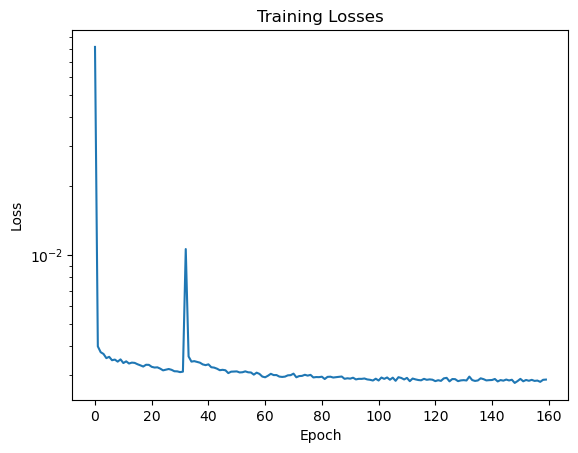

In [6]:
plt.plot(train_losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
None  # Suppress output.

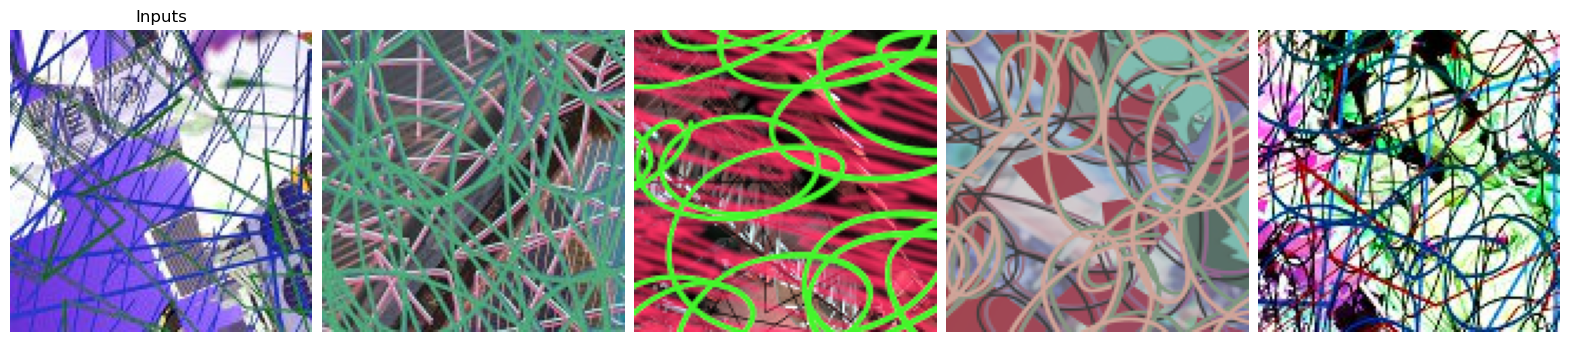

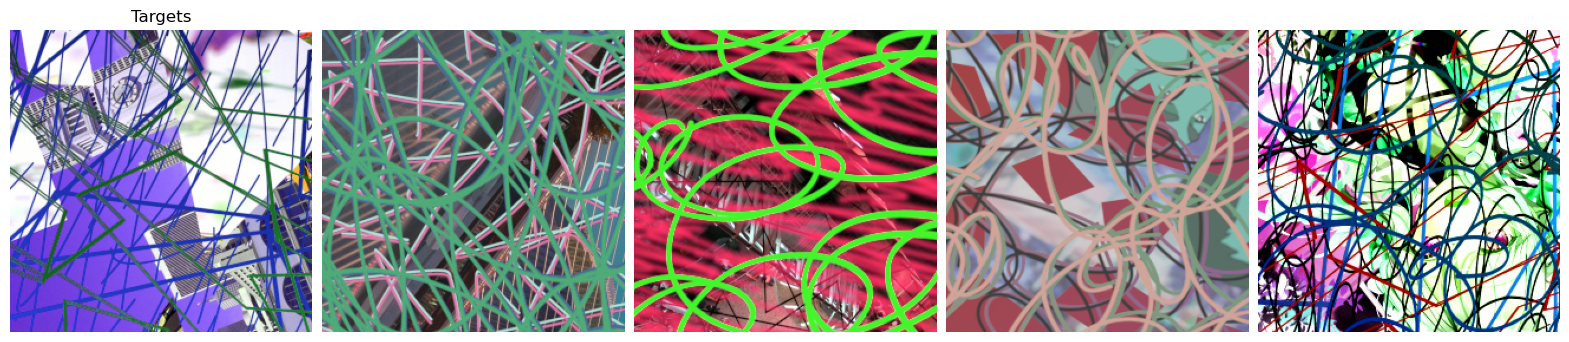

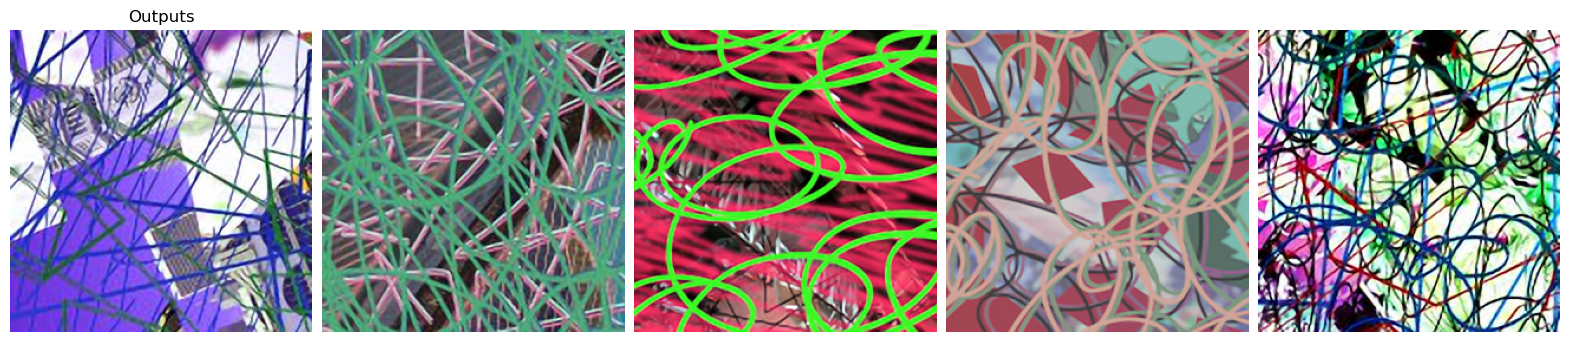

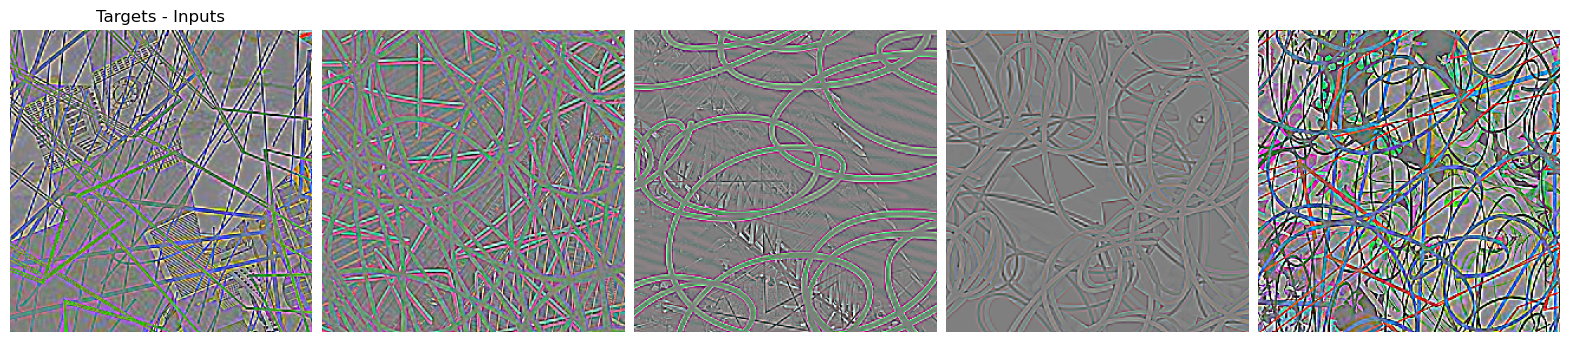

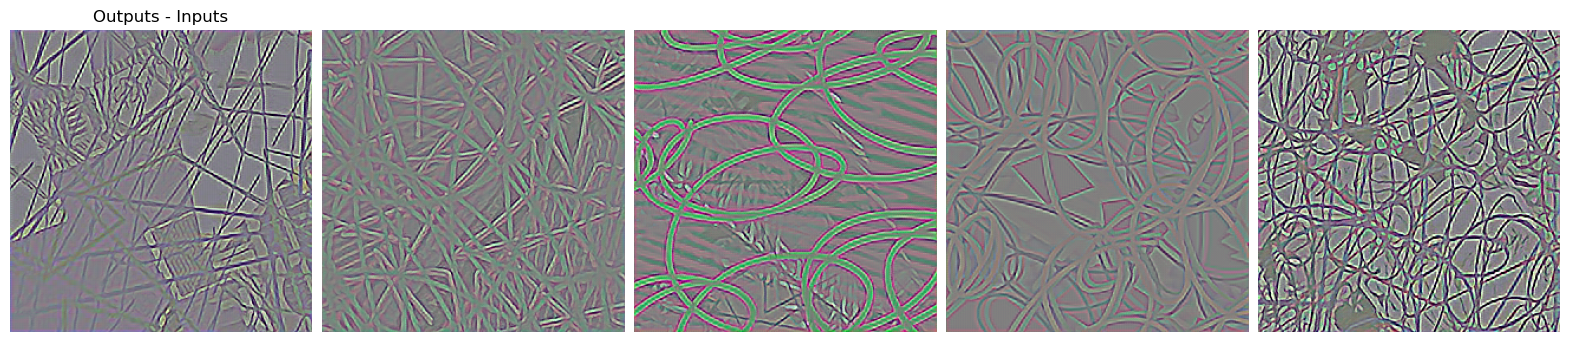

In [7]:
figsize = (20, 20)

with torch.inference_mode():
    inputs, targets = next(iter(DataLoader(train_set, batch_size=5)))
    model.eval()
    outputs = model(inputs)

figure = plt.figure(figsize=figsize)
show_images(figure, inputs)
figure.axes[0].set_title("Inputs")

figure = plt.figure(figsize=figsize)
show_images(figure, targets)
figure.axes[0].set_title("Targets")

figure = plt.figure(figsize=figsize)
show_images(figure, outputs)
figure.axes[0].set_title("Outputs")

upsampled_inputs = F.interpolate(inputs, scale_factor=2, mode="bilinear")

figure = plt.figure(figsize=figsize)
show_images(figure, targets - upsampled_inputs, value_range=(-0.2, 0.2))
figure.axes[0].set_title("Targets - Inputs")

figure = plt.figure(figsize=figsize)
show_images(figure, outputs - upsampled_inputs, value_range=(-0.2, 0.2))
figure.axes[0].set_title("Outputs - Inputs")

None  # Suppress output.